# Machine Translation

German-English

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("merged2015.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [0]:
#deu_eng = deu_eng[:50000,:]

# 3)-Text Pre-Processing

In [8]:
deu_eng

array([['india and japan prime ministers meet in tokyo',
        'die premierminister indiens und japans trafen sich in tokio'],
       ['indias new prime minister narendra modi is meeting his japanese counterpart shinzo abe in tokyo to discuss economic and security ties on his first major foreign visit since winning mays election',
        'indiens neuer premierminister narendra modi trifft bei seinem ersten wichtigen auslandsbesuch seit seinem wahlsieg im mai seinen japanischen amtskollegen shinzo abe in toko um wirtschaftliche und sicherheitspolitische beziehungen zu besprechen'],
       ['mr modi is on a fiveday trip to japan to strengthen economic ties with the third largest economy in the world',
        'herr modi befindet sich auf einer funftagigen reise nach japan um die wirtschaftlichen beziehungen mit der drittgroten wirtschaftsnation der welt zu festigen'],
       ...,
       ['five minutes later the first mountainbikers set off',
        'funf minuten spater legten die ers

In [9]:
type(deu_eng)

numpy.ndarray

In [10]:
deu_eng[0]

array(['india and japan prime ministers meet in tokyo',
       'die premierminister indiens und japans trafen sich in tokio'],
      dtype='<U511')

In [11]:
deu_eng[:5]

array([['india and japan prime ministers meet in tokyo',
        'die premierminister indiens und japans trafen sich in tokio'],
       ['indias new prime minister narendra modi is meeting his japanese counterpart shinzo abe in tokyo to discuss economic and security ties on his first major foreign visit since winning mays election',
        'indiens neuer premierminister narendra modi trifft bei seinem ersten wichtigen auslandsbesuch seit seinem wahlsieg im mai seinen japanischen amtskollegen shinzo abe in toko um wirtschaftliche und sicherheitspolitische beziehungen zu besprechen'],
       ['mr modi is on a fiveday trip to japan to strengthen economic ties with the third largest economy in the world',
        'herr modi befindet sich auf einer funftagigen reise nach japan um die wirtschaftlichen beziehungen mit der drittgroten wirtschaftsnation der welt zu festigen'],
       ['high on the agenda are plans for greater nuclear cooperation',
        'plane fur eine starkere kerntechnisch

In [12]:
# for english part 
deu_eng[:,0]

array(['india and japan prime ministers meet in tokyo',
       'indias new prime minister narendra modi is meeting his japanese counterpart shinzo abe in tokyo to discuss economic and security ties on his first major foreign visit since winning mays election',
       'mr modi is on a fiveday trip to japan to strengthen economic ties with the third largest economy in the world',
       ..., 'five minutes later the first mountainbikers set off',
       'bent hansen chairman of the association cycling on the grosser feldberg gave the starting orders and wished those taking part an enjoyable trip',
       'next year he hopes to have safety barriers on the course for the benefit of those taking part on the feldberg'],
      dtype='<U511')

**This shows all the dataset. I expect to show english version only.**

In [13]:
# for german part of lang.
deu_eng[:,1]

array(['die premierminister indiens und japans trafen sich in tokio',
       'indiens neuer premierminister narendra modi trifft bei seinem ersten wichtigen auslandsbesuch seit seinem wahlsieg im mai seinen japanischen amtskollegen shinzo abe in toko um wirtschaftliche und sicherheitspolitische beziehungen zu besprechen',
       'herr modi befindet sich auf einer funftagigen reise nach japan um die wirtschaftlichen beziehungen mit der drittgroten wirtschaftsnation der welt zu festigen',
       ..., 'funf minuten spater legten die ersten mountainbiker los',
       'bent hansen vorsitzender des vereins radeln auf den groen feldberg gab die startkommandos und wunschte den teilnehmern einen schonen ausflug',
       'fur nachstes jahr hoffe er dass es gelingt die strecke zum feldberg hinauf zur sicherheit der teilnehmer zu sperren'],
      dtype='<U511')

**I want to apply slice method as in array. Then I have one array with english version and other array in german. This not happening.
So when I will try to apply text cleaning or any other modeling technique, my data does not act as expected.**

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

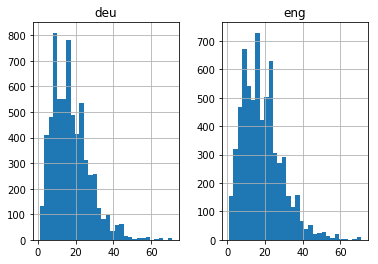

In [15]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 8 and that of the English phrases is 6.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [16]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)





English Vocabulary Size: 7231


In [17]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 9284


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode German sentences as the input sequences and English sentences as the target sequences

In [20]:
# english version
train[:, 0]

array(['its not my responsibility',
       'meanwhile in our homes items as innocuous as floor tiles or shed roofs have routinely contained asbestos',
       'she said i keep thinking this world did not get better within these years',
       ...,
       'crops are rotting in the fields mines have been deserted and the markets have been abandoned the virus has cost the region dearly',
       'the preparations for the party are well underway in tannenwald gun club which will celebrate years since being established on to september',
       'it also means higher taxes'], dtype='<U511')

In [21]:
# english version
train[:, 1]

array(['ich bin nicht dafur verantwortlich',
       'und derweil haben so unschuldige gegenstande in unseren hausern wie fubodenplatten oder schuppendacher standardmaig asbest enthalten',
       'sie sagte ich denke immer dass diese welt in diesen jahren nicht besser geworden ist',
       ...,
       'die ernte verrottet auf den feldern die minen sind verlassen und die markte verwaist das virus hat der region schwer zugesetzt',
       'auf hochtouren laufen beim schutzenverein tannenwald die vorbereitungen fur das grundungsfest von bis september',
       'sie bedeutet auch hohere steuern'], dtype='<U511')

In [0]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0]) 

# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [23]:
print(trainX[:5])

[[  15  184   18  272 1521    0    0    0]
 [1071   30 2751   59 6215 6216   85 1223]
 [ 197    4  261  100   18  323  708   16]
 [6478   55 1233  208 6479 6480  956 1466]
 [ 264    5  550    6    4  592    6  180]]


In [24]:
print(trainY[:5])

[[  48   23   51 4075    0    0    0    0]
 [2904   64 2016 5284   17 5285 2943   65]
 [ 141   97   23   98  179  362  193   58]
 [  69  610  427   23 1523 1892 2202 5445]
 [1329    3  113   76    1  204 3174    4]]


In [25]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(5205, 8)
(5205, 8)
(1302, 8)
(1302, 8)


### 4.3)- build NMT model

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [0]:
# model compilation (with 512 hidden units)
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 8, 512)            4753408   
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_3 (Dense)              (None, 8, 7231)           3709503   
Total params: 12,661,311
Trainable params: 12,661,311
Non-trainable params: 0
_________________________________________________________________


In [32]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 4164 samples, validate on 1041 samples
Epoch 1/30
4164/4164 [==============================] - 9s 2ms/step - loss: 7.8991 - acc: 0.0526 - val_loss: 6.9161 - val_acc: 0.0946

Epoch 00001: val_loss improved from inf to 6.91614, saving model to model_translate.h1
Epoch 2/30
4164/4164 [==============================] - 2s 506us/step - loss: 6.7410 - acc: 0.0947 - val_loss: 6.8209 - val_acc: 0.0908

Epoch 00002: val_loss improved from 6.91614 to 6.82092, saving model to model_translate.h1
Epoch 3/30
4164/4164 [==============================] - 2s 508us/step - loss: 6.6343 - acc: 0.0984 - val_loss: 6.7549 - val_acc: 0.0944

Epoch 00003: val_loss improved from 6.82092 to 6.75490, saving model to model_translate.h1
Epoch 4/30
4164/4164 [==============================] - 2s 504us/step - loss: 6.5841 - acc: 0.0973 - val_loss: 6.7269 - val_acc: 0.0953

Epoch 00004: val_loss improved from 6.75490 to 6.72691, saving model to model_translate.h1
Epoch 5/30
4164/4164 [=======================

# 5)-Plotting results

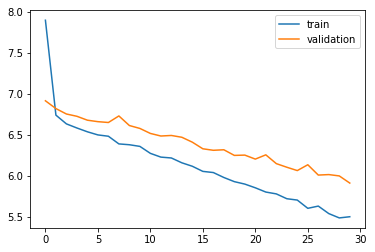

In [33]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 20 epochs.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (English)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], eng_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],eng_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [38]:
# 1st 15 rows
pred_df.head(15)

,actual,predicted
0,as competitors circle ever closer and new technology challenges cosy old certainties the imminent negotiation of the licence fee is fraught with especial danger for the bbc,the and the
1,luther rabinowitz collapsed his pyramid,i in
2,the health authorities recently explained that the disease has reached all corners of the country,the to the
3,i do not condone the tweet and i have taken it down the later post said,the
4,for the manager of the oberursel cult kiosk taking part in cycling events which go over the feldberg is perfectly natural,the
5,nato will not break their agreements with russian as a result of their planned deployment to east europe in response to the ukrainian crisis,the
6,another one who enjoyed himself was frittentoni,i was is the
7,the billion cruise industry is expected to benefit in the coming years from the rise of the middle class in emerging economies such as china and india,the and to and the
8,in addition to this the separatists reported that they have taken control of several towns and villages in the donezk region,the and to and the
9,kiev and moscow have agreed to new talks on gas,to and the to


In [39]:
# print 15 rows randomly 
pred_df.sample(15)

,actual,predicted
1105,businesses state and local tax burdens last year expanded by percent to billion compared with percent the year before and it was the third consecutive year of growth after backtoback years of shri...,the
1112,a woman has been hospitalised after screaming so hard during the ice bucket challenge that she dislocated her jaw,but my and to it
823,i now know that i can do it brilliant,i that to it
117,on the israeli side soldiers and six civilians including a thai worker were killed,and in said
260,no one it seems can be sure that they are safe,and in to said
807,we havent been playing as badly in recent weeks as it has been made out to be,and that to
1086,he was another one who did it all in one go as did nina kuhn press spokesperson for the oberursel council who did the route along side frank gruneisen,to and to a the to
1296,in one of abbotts patients arrived at his gps surgery with similar symptoms to him and was subsequently diagnosed with mesothelioma,the
673,the first day back at school is traditionally celebrated by children wearing embroidered shirts carrying balloons and giving flowers to their teachers,to and in to
1279,the hessian spd chairman thorsten schafergumbel who led the german delegation said to the host that he would keeps his ears open in germany for a possible partner,the and to the said
